In [ ]:
import pandas as pd
# Load dataset
df = pd.read_excel('/kaggle/input/augmented-isear/augmented_dataset.xlsx')
# Remove brackets [] from the 'content' column using pandas replace
df['content'] = df['content'].str.replace(r'[\[\]]', '', regex=True)



In [ ]:
import pandas as pd

# Load the first dataset
df1 = pd.read_excel('/kaggle/input/augmented-isear/augmented_dataset.xlsx')

# Load the second dataset
df2 = pd.read_excel('/kaggle/input/isear-data/ISEAR.xlsx')

# Remove brackets [] from the 'content' column in the first dataset
df1['content'] = df1['content'].str.replace(r'[\[\]]', '', regex=True)

# Concatenate the two DataFrames (vertically)
df = pd.concat([df1, df2], ignore_index=True)

# Display the first few rows of the combined DataFrame
print(df.tail())


In [ ]:
df = pd.read_excel('/kaggle/input/isear-data/ISEAR.xlsx')

In [ ]:

import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
# Load model directly
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("microsoft/deberta-v3-large",num_labels = 7)
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")

df = pd.read_excel('/kaggle/input/isear-data/ISEAR.xlsx')

#model = AutoModelForSequenceClassification.from_pretrained('/kaggle/working/model')
#tokenizer = AutoTokenizer.from_pretrained('/kaggle/working/token')


# Split dataset
Comment_train, Comment_test, Label_train, Label_test = train_test_split(df['content'], df['labels'], test_size=0.2, random_state=18)

# Tokenize data
encodedata_train = tokenizer.batch_encode_plus(
    Comment_train.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

encodedata_test = tokenizer.batch_encode_plus(
    Comment_test.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

# Prepare data for DataLoader
input_ids_train = encodedata_train['input_ids']
attention_masks_train = encodedata_train['attention_mask']
labels_train = torch.tensor(Label_train.to_numpy(), dtype=torch.long)

input_ids_test = encodedata_test['input_ids']
attention_masks_test = encodedata_test['attention_mask']
labels_test = torch.tensor(Label_test.to_numpy(), dtype=torch.long)

tensordataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
tensordataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

train_loader = DataLoader(tensordataset_train, batch_size = 8, shuffle=True)
test_loader = DataLoader(tensordataset_test, batch_size=8, shuffle=False)

# Define loss function and optimizer
loss_ftn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)  # Adjust learning rate as needed

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the number of epochs
num_epochs = 10

# Training and evaluation loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    # Training
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch
        optimizer.zero_grad()
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        # Compute loss
        loss = outputs['loss']
        # Backward pass
        loss.backward()
        # Update model parameters
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (progress_bar.n + 1)
        progress_bar.set_postfix({'Avg Loss': avg_loss})

    print(f"Epoch [{epoch + 1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_masks)
            _, predicted = torch.max(outputs['logits'], 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Accuracy on Test Data: {accuracy:.4f}')

    

In [ ]:
# Save the model and tokenizer
save_directory = "/kaggle/working/"
model.save_pretrained('model')
tokenizer.save_pretrained('token')


In [ ]:
df1

In [ ]:
import pandas as pd
a = pd.read_excel('/kaggle/input/augmented-isear/augmented_dataset.xlsx')

In [ ]:
a['content'] = a['content'].str.replace(r'[\[\]]', '', regex=True)

In [ ]:
a

In [ ]:
df.to_excel('combined dataset.xlsx')

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:551: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Epoch 1/10: 100%|██████████| 1804/1804 [14:30<00:00,  2.07batch/s, Avg Loss=1.18]


Epoch [1/10] - Avg Loss: 1.1772
Epoch [1/10] - Accuracy on Test Data: 0.7729


Epoch 2/10: 100%|██████████| 1804/1804 [14:30<00:00,  2.07batch/s, Avg Loss=0.543]


Epoch [2/10] - Avg Loss: 0.5427
Epoch [2/10] - Accuracy on Test Data: 0.8448


Epoch 3/10: 100%|██████████| 1804/1804 [14:30<00:00,  2.07batch/s, Avg Loss=0.299]


Epoch [3/10] - Avg Loss: 0.2995
Epoch [3/10] - Accuracy on Test Data: 0.8900


Epoch 4/10: 100%|██████████| 1804/1804 [14:30<00:00,  2.07batch/s, Avg Loss=0.18] 


Epoch [4/10] - Avg Loss: 0.1804
Epoch [4/10] - Accuracy on Test Data: 0.9162


Epoch 5/10: 100%|██████████| 1804/1804 [14:30<00:00,  2.07batch/s, Avg Loss=0.116]


Epoch [5/10] - Avg Loss: 0.1155
Epoch [5/10] - Accuracy on Test Data: 0.9315


Epoch 6/10: 100%|██████████| 1804/1804 [14:29<00:00,  2.07batch/s, Avg Loss=0.083] 


Epoch [6/10] - Avg Loss: 0.0830
Epoch [6/10] - Accuracy on Test Data: 0.9290


Epoch 7/10: 100%|██████████| 1804/1804 [14:29<00:00,  2.07batch/s, Avg Loss=0.094] 


Epoch [7/10] - Avg Loss: 0.0940
Epoch [7/10] - Accuracy on Test Data: 0.9306


Epoch 8/10: 100%|██████████| 1804/1804 [14:29<00:00,  2.07batch/s, Avg Loss=0.0672]


Epoch [8/10] - Avg Loss: 0.0672
Epoch [8/10] - Accuracy on Test Data: 0.9344


Epoch 9/10: 100%|██████████| 1804/1804 [14:29<00:00,  2.07batch/s, Avg Loss=0.0486]


Epoch [9/10] - Avg Loss: 0.0486
Epoch [9/10] - Accuracy on Test Data: 0.9359


Epoch 10/10: 100%|██████████| 1804/1804 [14:29<00:00,  2.07batch/s, Avg Loss=0.0436]


Epoch [10/10] - Avg Loss: 0.0436
Epoch [10/10] - Accuracy on Test Data: 0.9494


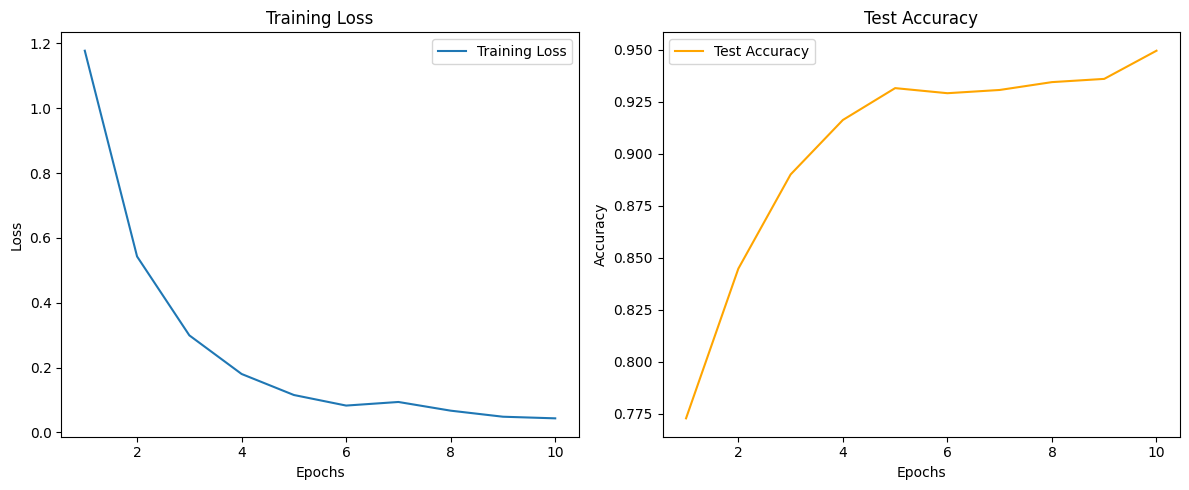

Evaluating: 100%|██████████| 451/451 [01:02<00:00,  7.20it/s]


Overall Performance Metrics:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       628
           1       0.97      0.92      0.95       662
           2       0.94      0.97      0.95       636
           3       0.91      0.91      0.91       630
           4       0.95      0.97      0.96       646
           5       0.97      0.97      0.97       678
           6       0.96      0.93      0.95       629

    accuracy                           0.95      4509
   macro avg       0.95      0.95      0.95      4509
weighted avg       0.95      0.95      0.95      4509


Overall Accuracy: 0.9494


Per-Class Performance:

Class 0: Accuracy = 0.9745
Class 1: Accuracy = 0.9245
Class 2: Accuracy = 0.9654
Class 3: Accuracy = 0.9111
Class 4: Accuracy = 0.9690
Class 5: Accuracy = 0.9720
Class 6: Accuracy = 0.9285


In [10]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import torch.nn.functional as F

# Custom Model Definition with DeBERTa and CNN layers
class DebertaWithCNN(nn.Module):
    def __init__(self, base_model_name, num_labels):
        super(DebertaWithCNN, self).__init__()
        self.deberta = AutoModel.from_pretrained(base_model_name, output_hidden_states=True)
        hidden_size = self.deberta.config.hidden_size
        
        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=hidden_size, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        
        # Fully connected layer for classification
        self.fc = nn.Linear(32, num_labels)
    
    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states[-1]  # Extract the last hidden state
        
        x = hidden_states.permute(0, 2, 1)  # Reshape to [batch_size, hidden_size, seq_length]
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Global max pooling
        x = F.max_pool1d(x, kernel_size=x.size(2)).squeeze(2)
        
        # Classification layer
        logits = self.fc(x)
        
        if labels is not None:
            loss = F.cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        else:
            return {"logits": logits}

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-large")

# Load dataset
df = pd.read_excel('/kaggle/input/combineddataset/combined dataset.xlsx')

# Split dataset
Comment_train, Comment_test, Label_train, Label_test = train_test_split(df['content'], df['labels'], test_size=0.2, random_state=18)

# Tokenize the data
encodedata_train = tokenizer.batch_encode_plus(
    Comment_train.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

encodedata_test = tokenizer.batch_encode_plus(
    Comment_test.astype(str).tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    max_length=100,
    return_tensors='pt',
    padding='max_length',
    truncation=True
)

# Prepare data for DataLoader
input_ids_train = encodedata_train['input_ids']
attention_masks_train = encodedata_train['attention_mask']
labels_train = torch.tensor(Label_train.to_numpy(), dtype=torch.long)

input_ids_test = encodedata_test['input_ids']
attention_masks_test = encodedata_test['attention_mask']
labels_test = torch.tensor(Label_test.to_numpy(), dtype=torch.long)

tensordataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
tensordataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

train_loader = DataLoader(tensordataset_train, batch_size=10, shuffle=True)
test_loader = DataLoader(tensordataset_test, batch_size=10, shuffle=False)

# Define model, loss function, and optimizer
model = DebertaWithCNN(base_model_name="microsoft/deberta-v3-large", num_labels=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_ftn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 10
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch')
    for batch in progress_bar:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_masks, labels = batch
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask=attention_masks, labels=labels)
        loss = outputs['loss']
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        avg_loss = total_loss / (progress_bar.n + 1)
        progress_bar.set_postfix({'Avg Loss': avg_loss})

    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Avg Loss: {avg_loss:.4f}")

    # Evaluation
    model.eval()
    total_correct = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_masks, labels = batch
            input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask=attention_masks)
            _, predicted = torch.max(outputs['logits'], 1)

            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = total_correct / total_samples if total_samples > 0 else 0
    test_accuracies.append(accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Accuracy on Test Data: {accuracy:.4f}')

# Plotting Loss and Accuracy graphs
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Loss graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Accuracy graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Detailed Performance Metrics Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating"):
        input_ids, attention_masks, labels = batch
        input_ids, attention_masks, labels = input_ids.to(device), attention_masks.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_masks)
        logits = outputs['logits']
        _, preds = torch.max(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Performance metrics
conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, labels=list(range(7)), zero_division=1)
accuracy = accuracy_score(all_labels, all_preds)

print("\nOverall Performance Metrics:\n")
print(class_report)
print(f"\nOverall Accuracy: {accuracy:.4f}\n")

# Per-class performance
print("\nPer-Class Performance:\n")
for i in range(7):  # Adjust number of classes accordingly
    class_accuracy = conf_matrix[i, i] / conf_matrix[i, :].sum() if conf_matrix[i, :].sum() > 0 else 0
    print(f"Class {i}: Accuracy = {class_accuracy:.4f}")


##### 